In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet

In [2]:
# Load the processed data
output_dir = '../processed_data'

# Load all region data from processed .pkl files
region_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]

region_data = {}
for file in region_files:
    region_name = file.replace('.pkl', '')
    df = pd.read_pickle(os.path.join(output_dir, file))
    region_data[region_name] = df

In [48]:
df = region_data['Zhemgang'].copy()

Test stationarity for original series
-------------------------------------
ADF Statistic: -8.543609898834179, p-value: 9.634577792645735e-14
KPSS Statistic: 0.02659464634546476, p-value: 0.1

Test stationarity for differenced series (order=1)
---------------------------------------------------
ADF Statistic: -25.486882319780655, p-value: 0.0
KPSS Statistic: 0.02792035666277221, p-value: 0.1

Test stationarity for differenced series (order=2)
---------------------------------------------------
ADF Statistic: -32.981748999721, p-value: 0.0
KPSS Statistic: 0.047309510945662804, p-value: 0.1


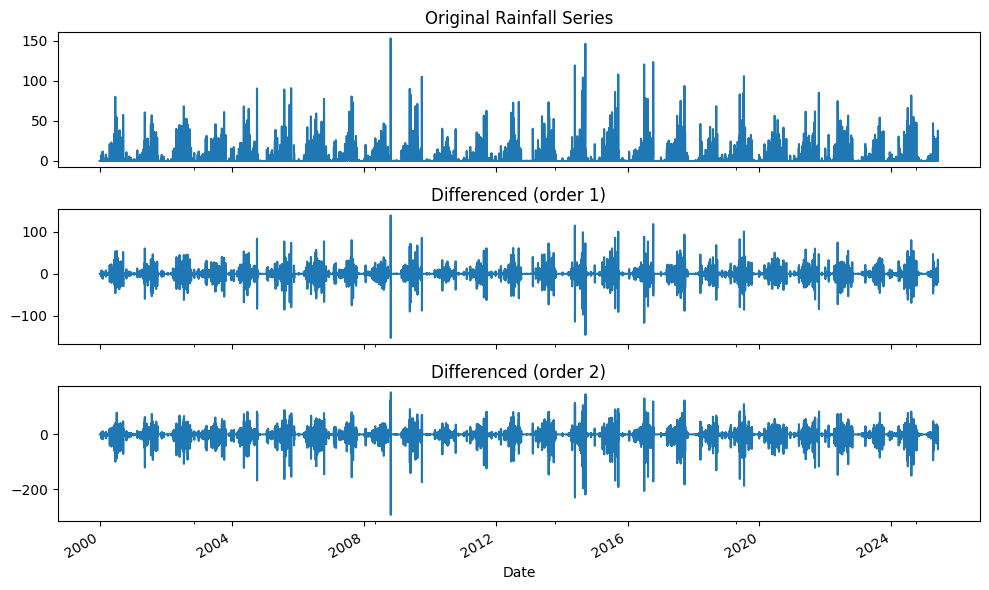

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller, kpss

# === Load your rainfall data ===
# df = pd.read_pickle("path_to/processed_zhemgang.pkl")  # Uncomment if needed
df = df.dropna(subset=["Rainfall"])
df = df.sort_values("Date")

# Set datetime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df['Rainfall']

# === Stationarity Tests ===
warnings.filterwarnings("ignore")

# First and second order differencing
data_diff_1 = data.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adf_result = adfuller(data)
kpss_result = kpss(data, regression='c')
print(f'ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('---------------------------------------------------')
adf_result = adfuller(data_diff_1)
kpss_result = kpss(data_diff_1, regression='c')
print(f'ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('---------------------------------------------------')
adf_result = adfuller(data_diff_2)
kpss_result = kpss(data_diff_2, regression='c')
print(f'ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# === Plot series ===
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
data.plot(ax=axs[0], title='Original Rainfall Series')
data_diff_1.plot(ax=axs[1], title='Differenced (order 1)')
data_diff_2.plot(ax=axs[2], title='Differenced (order 2)')
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error

# Suppress warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')

# --- Prepare Data ---
df = df[['Date', 'Rainfall']].dropna()
df.set_index('Date', inplace=True)
df = df.asfreq('D')  # ensure it's daily
data = df['Rainfall']

# --- Train/Test Split ---
train = data[:'2017-12-1']
test = data['2018-01-01':]

# --- Fit SARIMA Model ---
model = SARIMAX(train, 
                order=(1, 1, 1),              # ARIMA(p,d,q)
                seasonal_order=(1, 1, 1, 12), # SARIMA(P,D,Q,s)
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# Print model summary
print(model_fit.summary())

# --- Forecast ---
forecast = model_fit.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(pred.index, pred, label='Forecast', color='orange')
plt.fill_between(pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.title('SARIMA Daily Rainfall Forecast — Zhemgang')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluate ---
rmse = mean_squared_error(test, pred, squared=False)
print(f'RMSE on test set: {rmse:.3f}')


KeyError: "['Date'] not in index"